In [1]:
from src.data import *

import matplotlib.pyplot as plt

dataset = process_raw_data(year_start=2017)
dataset, binner = create_features(dataset, clip_max=50000, n_bins=5)
dataset.sort_values('claps', ascending=False)

raw ds shape: (7688, 8)
dropping 861 duplicates
dropping 1635 rows for 2017 year start
processed ds shape: (5192, 6)


,headline,claps,site_id,year,month,site,binned-class,log-claps,clip-claps,n-characters,n-words
4908,the most important skill nobody taught you,294000.0,personal-growth,2018,6,personal-growth,4.0,12.591335,50000.0,42,7
4621,travel is no cure for the mind,271000.0,personal-growth,2018,3,personal-growth,4.0,12.509874,50000.0,30,7
4622,the 3 keys to becoming irresistible,238000.0,personal-growth,2018,3,personal-growth,4.0,12.380026,50000.0,35,6
1264,im harvesting credit card numbers and password...,226000.0,hackernoon,2018,1,hackernoon,4.0,12.328290,50000.0,74,12
2426,how to think like a programmerlessons in probl...,210000.0,free-code-camp,2018,4,free-code-camp,4.0,12.254863,50000.0,56,9
...,...,...,...,...,...,...,...,...,...,...,...
1469,demystifying seth godins message on a year fr...,1.0,hackernoon,2019,11,hackernoon,0.0,0.000000,1.0,54,10
1561,emoji reactions,1.0,hackernoon,2020,9,hackernoon,0.0,0.000000,1.0,17,4
1587,three tech stories,1.0,hackernoon,2020,10,hackernoon,0.0,0.000000,1.0,18,3
1377,"ask me anything with bradley kam, co-founder o...",1.0,hackernoon,2020,7,hackernoon,0.0,0.000000,1.0,89,15


## Clap statistics

In [2]:
dataset['claps'].describe()

count      5192.000000
mean       4728.244029
std       11816.929519
min           1.000000
25%         443.000000
50%        1500.000000
75%        5000.000000
max      294000.000000
Name: claps, dtype: float64

## Distribution of claps

<AxesSubplot:ylabel='Frequency'>

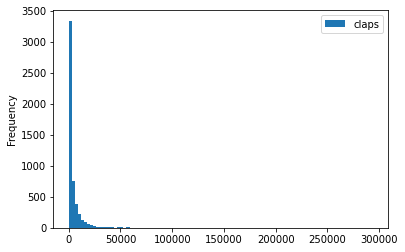

In [3]:
dataset.plot(y='claps', kind='hist', bins=100)

## Distribution of clipped claps

<AxesSubplot:ylabel='Frequency'>

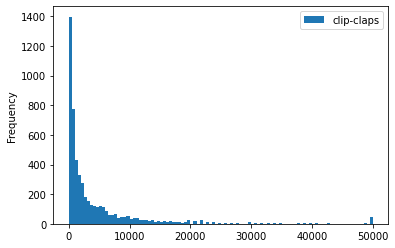

In [4]:
dataset.plot(y='clip-claps', kind='hist', bins=100)

## Distribution of log claps

<AxesSubplot:ylabel='Frequency'>

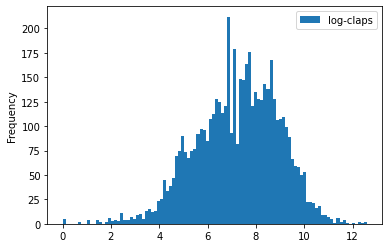

In [5]:
dataset.plot(y='log-claps', kind='hist', bins=100)

<AxesSubplot:ylabel='Frequency'>

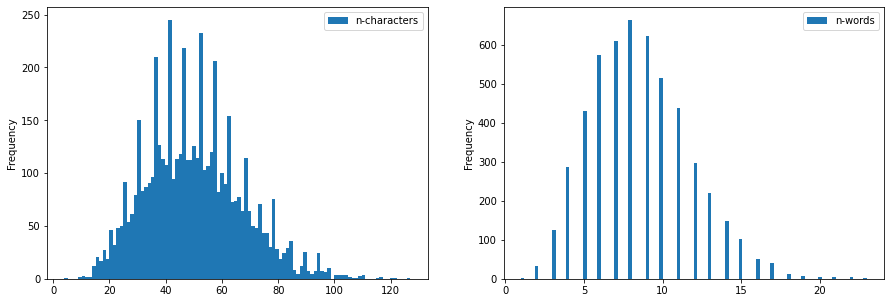

In [6]:
f, axes = plt.subplots(ncols=2, figsize=(15, 5))
dataset.plot(ax=axes[0], y='n-characters', kind='hist', bins=100)
dataset.plot(ax=axes[1], y='n-words', kind='hist', bins=100)

## Binning the claps

In [7]:
target = dataset.groupby('binned-class').count().loc[:, 'headline']
target

binned-class
0.0    1039
1.0    1021
2.0    1042
3.0    1049
4.0    1041
Name: headline, dtype: int64

<AxesSubplot:xlabel='binned-class'>

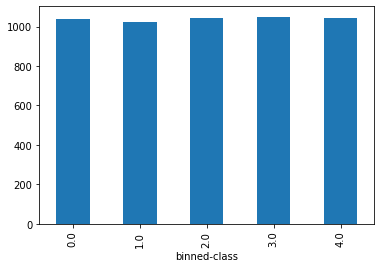

In [8]:
target.plot(kind='bar')

In [9]:
edges = binner.bin_edges_
for label, edge in enumerate(edges[0].flatten().tolist()[1:]):
    print(f'label {label} ends at {int(edge)}')

label 0 ends at 312
label 1 ends at 1000
label 2 ends at 2400
label 3 ends at 6200
label 4 ends at 294000


## How do claps change over time?

<AxesSubplot:xlabel='year'>

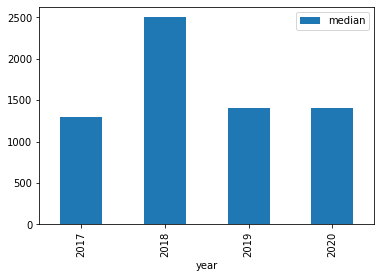

In [20]:
years = dataset.groupby('year').agg({'claps': ['median', 'mean']})
years.columns = years.columns.get_level_values(1)
years.plot(kind='bar', y='median')

<AxesSubplot:xlabel='month'>

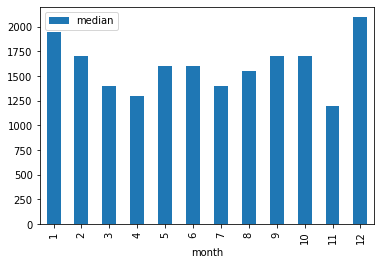

In [22]:
months = dataset.groupby('month').agg({'claps': ['median', 'mean']})
months.columns = months.columns.get_level_values(1)
months.plot(kind='bar', y='median')

## By site

In [12]:
sites = dataset.groupby('site_id').agg({'claps': ['median', 'mean', 'count']})
sites.columns = sites.columns.get_level_values(1)
sites.sort_values('median')

,median,mean,count
site_id,,,
level-up-web,172.0,329.000000,367
dailyjs,482.0,979.874552,279
levelup,699.0,1353.288360,378
writingcooperative,809.0,1756.051613,465
the-ascent,1000.0,3192.307527,465
the-mission,1300.0,5387.320106,378
better-programming,1500.0,3278.588235,408
better-humans,1650.0,3511.771111,450
hackernoon,2500.0,7414.666667,357


## By site and year

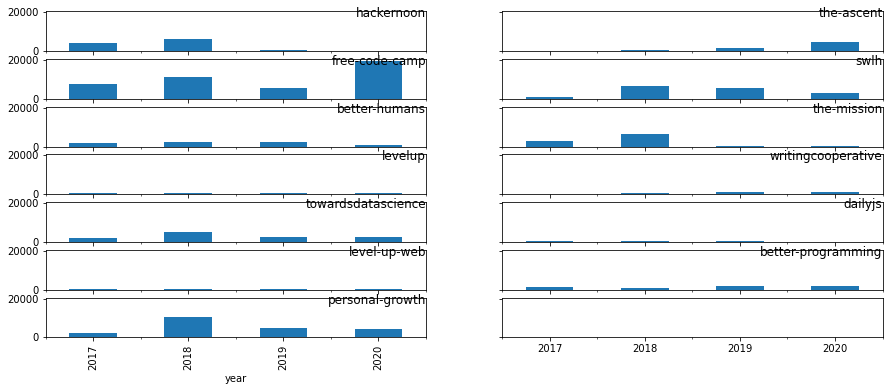

In [13]:
from math import ceil

sites = list(set(dataset['site_id']))
f, axes = plt.subplots(ncols=2, nrows=ceil(len(sites) / 2), sharex=True, sharey=True, figsize=(15, 6))

for site, ax in zip(sites, axes.flatten()):
    mask = dataset.loc[:, 'site_id'] == site
    subset = dataset.loc[mask, :]
    grp = subset.groupby('year').agg({'claps': 'median'})
    grp.plot(ax=ax, kind='bar')
    ax.get_legend().remove()
    ax.set_title(site, loc='right', y=0.7)

## Headline features

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

vec = CountVectorizer()
x = vec.fit_transform(dataset['headline'])
x = x.todense()
print(x.shape)

(5192, 6139)


In [15]:
names = np.array(vec.get_feature_names())
counts = np.squeeze(np.array(x.sum(axis=0)))

In [16]:
counts[:10]

array([ 37,   2,   1,   8, 171,  24,   4,   1,   1,   2])

In [17]:
sort_idx = np.squeeze(np.array(counts.argsort()))

In [18]:
counts[sort_idx][-32:]

array([ 149,  149,  149,  152,  152,  156,  158,  171,  171,  171,  179,
        210,  212,  218,  234,  234,  241,  251,  260,  264,  280,  352,
        502,  564,  678,  716,  746,  854,  884, 1165, 1261, 2158])

In [19]:
names[sort_idx][-32:]

array(['can', 'should', 'things', 'best', 'learning', 'do', 'using', '10',
       'python', 'javascript', 'guide', 'my', 'an', 'from', 'that', 'on',
       'life', 'writing', 'what', 'react', 'why', 'is', 'with', 'for',
       'of', 'you', 'your', 'in', 'and', 'how', 'the', 'to'], dtype='<U43')